<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/SMB_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.24.0
# !pip install scipy==1.9.0


ERROR: Operation cancelled by user


In [1]:
import numpy as np
print(np.__version__)
import scipy as sp
print(sp.__version__)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
from scipy.optimize import minimize, NonlinearConstraint

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy import integrate
import warnings




2.0.2
1.14.1


In [42]:
# smb model
# # tips:
    # - the Error: "IndexError: index 10 is out of bounds for axis 0 with size 9"
    # may be due to a miss-match in size between the initial conditons and c, q in the ode func.
# IMPORTING LIBRARIES
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Loading the Plotting Libraries
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from PIL import Image
from scipy import integrate
# import plotly.graph_objects as go
import pandas as pd
import json
import os
import time
###########################################
# IMPORTING MY OWN FUNCTIONS
###########################################
# from post_pre_processing_funcs import

# INPUTS
#######################################################

# UNITS:
# All units must conform to:
# Time - s
# Lengths - cm^2
# Volumes - cm^3
# Masses - g
# Concentrations - g
# Volumetric flowrates - cm^3/s


def SMB(SMB_inputs):
    iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets = SMB_inputs[0:]

    ###################### (CALCUALTED) SECONDARY INPUTS #########################

    # Column Dimensions:
    ################################################################
    F = (1-e)/e     # Phase ratio
    t=0
    t_sets = 0
    Ncol_num = np.sum(zone_config) # Total number of columns
    L_total = L*Ncol_num # Total Lenght of all columns
    A_col = np.pi*0.25*d_col**2 # cm^2
    V_col = A_col * L # cm^3
    V_col_total = Ncol_num * V_col # cm^3
    A_in = np.pi * (d_in/2)**2 # cm^2
    alpha = A_in / A_col



    # Time Specs:
    ################################################################

    t_index = t_index_min*60 # s #

    # Notes:
    # - Cyclic Steady state typically happens only after 10 cycles (ref: https://doi.org/10.1205/026387603765444500)
    # - The system is not currently designed to account for periods of no external flow

    n_1_cycle = t_index * Ncol_num  # s How long a single cycle takes

    total_cycle_time = n_1_cycle*n_num_cycles # s

    tend = total_cycle_time # s # Final time point in ODE solver

    tend_min = tend/60

    t_span = (0, tend) # +dt)  # from t=0 to t=n

    num_of_injections = int(np.round(tend/t_index)) # number of switching periods

    # 't_start_inject_all' is a vecoter containing the times when port swithes occur for each port
    # Rows --> Different Ports
    # Cols --> Different time points
    t_start_inject_all = [[] for _ in range(Ncol_num)]  # One list for each node (including the main list)

    # Calculate start times for injections
    for k in range(num_of_injections):
        t_start_inject = k * t_index
        t_start_inject_all[0].append(t_start_inject)  # Main list
        for node in range(1, Ncol_num):
            t_start_inject_all[node].append(t_start_inject + node * 0)  # all rows in t_start_inject_all are identical

    t_schedule = t_start_inject_all[0]

    # REQUIRED FUNCTIONS:
    ################################################################

    # 1.
    # Func to Generate Indices for the columns
    # def generate_repeated_numbers(n, m):
    #     result = []
    #     n = int(n)
    #     m = int(m)
    #     for i in range(m):
    #         result.extend([i] * n)
    #     return result

    # 3.
    # Func to divide the column into nodes

    # DOES NOT INCLUDE THE C0 NODE (BY DEFAULT)
    def set_x(L, Ncol_num,nx_col,dx):
        if nx_col == None:
            x = np.arange(0, L+dx, dx)
            nnx = len(x)
            nnx_col = int(np.round(nnx/Ncol_num))
            nx_BC = Ncol_num - 1 # Number of Nodes (mixing points/boundary conditions) in between columns

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.
            return x, dx, nnx_col,  nnx, nx_BC

        elif dx == None:
            nx = Ncol_num * nx_col
            nx_BC = Ncol_num - 1 # Number of Nodes in between columns
            x = np.linspace(0,L_total,nx)
            ddx = x[1] - x[0]

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.

            return x, ddx, nx_col, nx, nx_BC

    # 4. A func that:
    # (i) Calcualtes the internal flowrates given the external OR (ii) Visa-versa
    def set_flowrate_values(set_Q_int, set_Q_ext, Q_rec):
        if set_Q_ext is None and Q_rec is None:  # Chosen to specify internal/zone flowrates
            Q_I = set_Q_int[0]
            Q_II = set_Q_int[1]
            Q_III = set_Q_int[2]
            Q_IV = set_Q_int[3]

            QX = -(Q_I - Q_II)
            QF = Q_III - Q_II
            QR = -(Q_III - Q_IV)
            QD = -(QF + QX + QR) # OR: Q_I - Q_IV

            Q_ext = np.array([QF, QR, QD, QX]) # cm^3/s

            return Q_ext

        elif set_Q_int is None and Q_rec is not None:  # Chosen to specify external flowrates
            QF = set_Q_ext[0]
            QR = set_Q_ext[1]
            QD = set_Q_ext[2]
            QX = set_Q_ext[3]

            Q_I = Q_rec  # m^3/s
            Q_III = (QX + QF) + Q_I
            Q_IV = (QD - QX) + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet
            Q_II = (QR - QX) + Q_IV
            Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
            return Q_internal


    # 5. Function to Build Port Schedules:

    # This is done in two functions: (i) repeat_array and (ii) build_matrix_from_vector
    # (i) repeat_array
    # Summary: Creates the schedule for the 1st port, port 0, only. This is the port boadering Z2 & Z3 and always starts as a Feed port at t=0
    # (i) build_matrix_from_vector
    # Summary: Takes the output from "repeat_array" and creates schedules for all other ports.
    # The "trick" is that the states of each of the, n, ports at t=0, is equal to the first, n, states of port 0.
    # Once we know the states for each port at t=0, we form a loop that adds the next state.

    # 5.1
    def position_maker(schedule_quantity_name, F, R, D, X, Z_config):

        """

        Function that initializes the starting schedueles for a given quantitiy at all positions

        F, R, D and X are the values of the quantiity at the respective feed ports

        """
        # Initialize:
        X_j = np.zeros(Ncol_num)


        # We set each port in the appropriate position, depending on the nuber of col b/n Zones:
        # By default, Position i = 0 (entrance to col,0) is reserved for the feed node.

        # Initialize Positions:
        # Q_position is a vector whose len is = number of mixing points (ports) b/n columns

        X_j[0] = F        # FEED
        X_j[Z_config[2]] = R     # RAFFINATE
        X_j[Z_config[2] + Z_config[3]] = D    # DESORBENT
        X_j[Z_config[2] + Z_config[3]+  Z_config[0]] = X   # EXTRACT

        return X_j

    # 5.2
    def repeat_array(vector, start_time_num):
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        # start_time_num = The number of times the state changes == num of port switches == num_injections
        repeated_array = np.tile(vector, (start_time_num // len(vector) + 1))
        return repeated_array[:start_time_num]

    def initial_u_col(Zconfig, Qint):
        """
        Fun that returns the the inital state at t=0 of the volumetric
        flows in all the columns.

        """
        # First row is for col0, which is the feed to zone 3
        Zconfig_roll = np.roll(Zconfig, -2)
        Qint_roll = np.roll(Qint, -2)

        # print(Qint)
        X = np.array([])

        for i in range(len(Qint_roll)):
            X_add = np.ones(Zconfig_roll[i])*Qint_roll[i]
            # print('X_add:\n', X_add)

            X = np.append(X, X_add)
        # X = np.concatenate(X)
        # print('X:\n', X)
        return X


    def build_matrix_from_vector(vector, t_schedule):
        """
        Fun that returns the schedeule given the inital state at t=0
        vector: inital state of given quantity at t=0 at all nodes
        t_schedule: times at which port changes happen

        """
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        start_time_num = int(len(t_schedule))
        vector = np.array(vector)  # Convert the vector to a NumPy array
        n = len(vector) # number of ports/columns

        # Initialize the matrix for repeated elements, ''ALL''
        ALL = np.zeros((n, start_time_num), dtype=vector.dtype)  # Shape is (n, start_time_num)

        for i in range(start_time_num):
            # print('i:',i)
            ALL[:, i] = np.roll(vector, i)
        return ALL



    # # Uncomment as necessary depending on specification of either:
    # # (1) Internal OR (2) External flowrates :
    # # (1)
    # Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    Q_external = set_flowrate_values(Q_internal, None, None) # Order: QF, QR, QD, QX
    QF, QR, QD, QX = Q_external[0], Q_external[1], Q_external[2], Q_external[3]
    # print('Q_external:', Q_external)

    # (2)
    # QX, QF, QR = -0.277, 0.315, -0.231  # cm^3/s
    # QD = - (QF + QX + QR)
    # Q_external = np.array([QF, QR, QD, QX])
    # Q_rec = 33.69 # cm^3/s
    # Q_internal = set_flowrate_values(None, Q_external, Q_rec) # Order: QF, QR, QD, Q

    ################################################################################################


    # Make concentration schedules for each component

    Cj_pulse_all = [[] for _ in range(num_comp)]
    for i in range(num_comp):
        Cj_position = []
        Cj_position = position_maker('Feed Conc Schedule:', parameter_sets[i]['C_feed'], 0, 0, 0, zone_config)
        Cj_pulse = build_matrix_from_vector(Cj_position,  t_schedule)
        Cj_pulse_all[i] = Cj_pulse


    Q_position = position_maker('Vol Flow Schedule:', Q_external[0], Q_external[1], Q_external[2], Q_external[3], zone_config)
    Q_pulse_all = build_matrix_from_vector(Q_position,  t_schedule)

    # Spacial Discretization:
    # Info:
    # nx --> Total Number of Nodes (EXCLUDING mixing points b/n nodes)
    # nx_col --> Number of nodes in 1 column
    # nx_BC --> Number of mixing points b/n nodes
    x, dx, nx_col, nx, nx_BC = set_x(L=L_total, Ncol_num = Ncol_num, nx_col = nx_per_col, dx = None)
    start = [i*nx_col for i in range(0,Ncol_num)] # Locations of the BC indecies
    u_col_at_t0 = initial_u_col(zone_config, Q_internal)
    Q_col_all = build_matrix_from_vector(u_col_at_t0, t_schedule)


    # DISPLAYING INPUT INFORMATION:
    # print('---------------------------------------------------')
    # print('Number of Components:', num_comp)
    # print('---------------------------------------------------')
    # print('\nTime Specs:\n')
    # print('---------------------------------------------------')
    # print('Number of Cycles:', n_num_cycles)
    # print('Time Per Cycle:', n_1_cycle/60, "min")
    # print('Simulation Time:', tend_min, 'min')
    # print('Index Time:', t_index, 's OR', t_index/60, 'min' )
    # print('Number of Port Switches:', num_of_injections)
    # print('Injections happen at t(s) = :', t_schedule, 'seconds')
    # print('---------------------------------------------------')
    # print('\nColumn Specs:\n')
    # print('---------------------------------------------------')
    # print('Configuration:', zone_config, '[Z1,Z2,Z3,Z4]')
    # print(f"Number of Columns: {Ncol_num}")
    # print('Column Length:', L, 'cm')
    # print('Column Diameter:', d_col, 'cm')
    # print('Column Volume:', V_col, 'cm^3')
    # print("alpha:", alpha, '(alpha = A_in / A_col)')
    # print("Nodes per Column:",nx_col)
    # print("Boundary Nodes locations,x[i], i =", start)
    # print("Total Number of Nodes (nx):",nx)
    # print('---------------------------------------------------')
    # print('\nFlowrate Specs:\n')
    # print('---------------------------------------------------')
    # print("External Flowrates =", Q_external, '[F,R,D,X] ml/min')
    # print("Ineternal Flowrates =", Q_internal, 'ml/min')
    # print('---------------------------------------------------')
    # print('\nPort Schedules:')
    # for i in range(num_comp):
    #     print(f"Concentration Schedule:\nShape:\n {Names[i]}:\n",np.shape(Cj_pulse_all[i]),'\n', Cj_pulse_all[i], "\n")
    # print("Injection Flowrate Schedule:\nShape:",np.shape(Q_pulse_all),'\n', Q_pulse_all, "\n")
    # print("Respective Column Flowrate Schedule:\nShape:",np.shape(Q_col_all),'\n', Q_col_all, "\n")



    # ###########################################################################################

    # Isotherm Models:


    ###########################################################################################

    # 1. LINEAR
    def iso_lin(theta_lin, c):
        # params: [HA, HB]
        H = theta_lin
        q_star = H*c

        return q_star # [qA, qB, ...]

    # 2.  LANGMUIR

    # 2.1 Independent Langmuir
    def iso_langmuir(theta_lang, c, comp_idx): # already for specific comp
        H = theta_lang
        q_star = H*c/(1 + H*c)
        #q_star = H[comp_idx]*c/(1 + K[0]*c + K[1]*c)
        # q_star = theta_lang[0]*c/(1 + theta_lang[1]*c + theta_lang[2]*c) +\
        #     theta_lang[3]*c/(1 + theta_lang[4]*c + theta_lang[5]*c)
        return q_star

    # 2.3 Coupled Langmuir
    def iso_cup_langmuir(theta_cuplang, c, IDX, comp_idx): # already for specific comp
        H = theta_cuplang[:2] # [HA, HB]
        K = theta_cuplang[2:] # [KA, KB]
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]
        q_star = H[comp_idx]*c_i[comp_idx]/(1 + K[0]*cA + K[1]*cB)
        return q_star

    # 2.3 Bi-Langmuir
    def iso_bi_langmuir(theta_bl, c, IDX, comp_idx): # already for specific comp
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]

        q_star = theta_bl[0]*c_i[comp_idx]/(1 + theta_bl[1]*cA + theta_bl[2]*cB) +\
                theta_bl[3]*c_i[comp_idx]/(1 + theta_bl[4]*cA + theta_bl[5]*cB)

        return q_star


    # 3. FREUDLICH:
    def iso_freundlich(theta_fre, c): # already for specific comp
        q_star = theta_fre[0]*c**(1/theta_fre[1])
        return q_star





    ###########################################################################################

    ###########################################################################################

    # Mass Transfer (MT) Models:

    def mass_transfer(kav_params, q_star, q): # already for specific comp
        # kav_params: [kA, kB]
        kav =  kav_params
        MT = kav * Bm/(5 + Bm) * (q_star - q)
        # MT = kav * (q_star - q)
        return MT

    # MT PARAMETERS
    ###########################################################################################
    # print('np.shape(parameter_sets[:]["kh"]):', np.shape(parameter_sets[3]))
    kav_params = [parameter_sets[i]["kh"] for i in range(num_comp)]  # [kA, kB, kC, kD, kE, kF]
    # print('kav_params:', kav_params)
    # print('----------------------------------------------------------------')
    ###########################################################################################

    # # FORMING THE ODES


    # Form the remaining schedule matrices that are to be searched by the funcs

    # Column velocity schedule:
    u_col_all = -Q_col_all/A_col/e

    # Column Dispersion schedule:
    # Different matrices for each comp because diff Pe's for each comp
    D_col_all = []
    for i in range(num_comp): # for each comp
        D_col = -(u_col_all*L)/Pe_all[i] # constant dispersion coeff
        D_col_all.append(D_col)

    # Storage Spaces:
    coef_0 = np.zeros_like(u_col_all)
    coef_1 = np.zeros_like(u_col_all)
    coef_2 = np.zeros_like(u_col_all)

    # coef_0, coef_1, & coef_2 correspond to the coefficents of ci-1, ci & ci+1 respectively
    # These depend on u and so change with time, thus have a schedule

    # From descritization:
    coef_0_all = []
    coef_1_all = []
    coef_2_all = []
    for j in range(num_comp): # for each comp
        for i  in range(Ncol_num): # coefficients for each col
            coef_0[i,:] = ( D_col_all[j][i,:]/dx**2 ) - ( u_col_all[i,:]/dx ) # coefficeint of i-1
            coef_1[i,:] = ( u_col_all[i,:]/dx ) - (2*D_col_all[j][i,:]/(dx**2))# coefficeint of i
            coef_2[i,:] = (D_col_all[j][i,:]/(dx**2))    # coefficeint of i+1
        coef_0_all.append(coef_0)
        coef_1_all.append(coef_1)
        coef_2_all.append(coef_2)

    # All shedules:
    # For each shceudle, rows => col idx, columns => Time idx
    # :
    # - Q_pulse_all: Injection flowrates
    # - C_pulse_all: Injection concentrations for each component
    # - Q_col_all:  Flowrates WITHIN each col
    # - u_col_all: Linear velocities WITHIN each col
    # - D_col_all: Dispersion coefficeints WITHIN each col
    # - coef_0, 1 and 2: ci, ci-1 & ci+1 ceofficients

    # print('coef_0:\n',coef_0)
    # print('coef_1:\n',coef_1)
    # print('coef_2:\n',coef_2)
    # print('\nD_col_all:\n',D_col_all)
    # print('Q_col_all:\n',Q_col_all)
    # print('A_col:\n',A_col)
    # print('u_col_all:\n',u_col_all)


    def coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)
        get_C = lambda t, C_schedule, col_idx, comp_idx: next((C_schedule[comp_idx][col_idx][j] for j in range(len(C_schedule[comp_idx][col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)

        def small_col_matix(nx_col, col_idx):
        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            # get_C(t, coef_0_all, k, comp_idx)
            # small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[0,0], small_col_coeff[0,1] = get_C(t,coef_1_all,col_idx, comp_idx), get_C(t,coef_2_all,col_idx, comp_idx)
            # for c2:
            # small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_C(t,coef_0_all,col_idx, comp_idx), get_C(t, coef_1_all, col_idx, comp_idx), get_C(t, coef_2_all,col_idx, comp_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_C(t,coef_2_all,col_idx, comp_idx) # coef_1 + coef_2 account for rolling boundary


            return small_col_coeff


        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        # Add the cols
        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matix(nx_col,col_idx)
        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start, comp_idx):
            vec_add = np.zeros(nx)
            c_BC = np.zeros(Ncol_num)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #  start[i] => the node at the entrance to the ith col
                # So start[3] is the node representing the 1st node in col 3

                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:

                c_injection = get_C(t, Cj_pulse_all, i, comp_idx)

                if Q_2 > 0: # Concentration in the next column is only affected for injection flows IN
                    C_IN = W1 * c[i*nx_col-1] + W2 * c_injection
                else:
                    # C_IN = c[i*nx_col-1] # no change in conc during product collection
                    C_IN = c[start[i]-1] # no change in conc during product collection

                # Calcualte alpha, bata and gamma:
                # Da = get_X(t, D_col_all, i)
                Da = get_C(t, D_col_all, i, comp_idx)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                c_BC[i] = R1 * C_IN - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node

            # print('c_BC:\n', c_BC)

            for k in range(len(c_BC)):
                # vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[start[k]]  = get_C(t, coef_0_all, k, comp_idx)*c_BC[k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return larger_coeff_matrix, vector_add(nx, c, start, comp_idx)

    def coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start_CUP, alpha, c, nx_col,IDX): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)


        # 1. From coefficent "small" matrix for movement of single comp through single col
        # 2. Form  "large" coefficent matrix for movement through one all cols
        # 3. The large  coefficent matrix for each comp will then be combined into Final Matrix

        # 1.
        def small_col_matrix(nx_col, col_idx):

        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            #
            small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            # for c2:
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_X(t,coef_2,col_idx) # coef_1 + coef_2 account for rolling boundary

            return small_col_coeff

        # 2. Func to Build Large Matrix

        def matrix_builder(M, M0):
            # M = Matrix to add (small)
            # M0 = Initial state of the larger matrix to be added to
            nx_col = M.shape[0]
            repeat = int(np.round(M0.shape[0]/M.shape[0]))# numbner of times the small is added to the larger matrix
            for col_idx in range(repeat):
                        M0[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = M
            return M0


        # 3. Generate and Store the Large Matrices
        # Storage Space:
        # NOTE: Assuming all components have the same Dispersion coefficients,
        # all components will have the same large_col_matrix
        # Add the cols
        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matrix(nx_col,col_idx)

        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # Inital final matrix:
        n = nx*num_comp
        final_matrix0 = np.zeros((n,n))


        final_matrix = matrix_builder(larger_coeff_matrix, final_matrix0)

            # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start):
            vec_add = np.zeros(nx*num_comp)
            c_BC = np.zeros(nx*num_comp)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #k = i%len(start) # Recounts columns for B
                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:
                # Identifiers:
                A = IDX[0]
                B = IDX[1]

                # C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, C_pulse_all_A, i) # c[-1] conc out the last col
                # C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, C_pulse_all_B, i) # c[-1] conc out the last col

                C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[0], i) # c[-1] conc out the last col
                C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[1], i) # c[-1] conc out the last col


                # Calcualte alpha, bata and gamma:
                Da = get_X(t, D_col_all, i)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                # print('j:', j)
                c_BC[i] = R1 * C_IN_A - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node
                c_BC[B + i] = R1 * C_IN_B - R2 * c[B+j] + R3 * c[B+j+1]
            # print('c_BC:\n', c_BC)
            # print('c_BC.shape:\n', c_BC.shape)

            for k in range(len(start)):
                vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[B + start[k]]  = get_X(t,coef_0,k)*c_BC[B+ k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return final_matrix, vector_add(nx, c, start_CUP)

    # ###########################################################################################

    # # mod1: UNCOUPLED ISOTHERM:
    # # Profiles for each component can be solved independently

    # ###########################################################################################
    def mod1(t, v, comp_idx, Q_pulse_all):
        # call.append("call")
        # print(len(call))
        c = v[:nx]
        q = v[nx:]

        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)
        # print('v size\n',np.shape(v))

        # Isotherm:
        #########################################################################
        isotherm = iso_lin(theta_lin[comp_idx], c)
        #isotherm = iso_langmuir(theta_lang[comp_idx], c, comp_idx)
        #isotherm = iso_freundlich(theta_fre, c)


        # Mass Transfer:
        #########################################################################
        # print('isotherm size\n',np.shape(isotherm))
        MT = mass_transfer(kav_params[comp_idx], isotherm, q)
        #print('MT:\n', MT)

        coeff_matrix, vec_add = coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)
        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    def mod2(t, v):

        # where, v = [c, q]
        c = v[:num_comp*nx] # c = [cA, cB] | cA = c[:nx], cB = c[nx:]
        q = v[num_comp*nx:] # q = [qA, qB]| qA = q[:nx], qB = q[nx:]

        # Craate Lables so that we know the component assignement in the c vecotor:
        A, B = 0*nx, 1*nx # Assume Binary 2*nx, 3*nx, 4*nx, 5*nx
        IDX = [A, B]

        # Thus to refer to the liquid concentration of the i = nth row of component B: c[C + n]
        # Or the the solid concentration 10th row of component B: q[B + 10]
        # Or to refer to all A's OR B's liquid concentrations: c[A + 0: A + nx] OR c[B + 0: B + nx]


        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)


        coeff_matrix, vec_add = coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, IDX)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)



        ####################### Building MT Terms ####################################################################

        # Initialize

        MT = np.zeros(len(c)) # column vector: MT kinetcis for each comp: MT = [MT_A MT_B]

        for comp_idx in range(num_comp): # for each component

            ######################(i) Isotherm ####################################################################

            # Comment as necessary for required isotherm:
            # isotherm = iso_bi_langmuir(theta_blang[comp_idx], c, IDX, comp_idx)
            isotherm = iso_cup_langmuir(theta_cup_lang, c, IDX, comp_idx)
            # print('qstar:\n', isotherm.shape)
            ################### (ii) MT ##########################################################
            MT_comp = mass_transfer(kav_params[comp_idx], isotherm, q[IDX[comp_idx] + 0: IDX[comp_idx] + nx ])
            MT[IDX[comp_idx] + 0: IDX[comp_idx] + nx ] = MT_comp
            # [MT_A, MT_B, . . . ] KINETICS FOR EACH COMP



        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    # SOLVING THE ODES
    # creat storage spaces:
    y_matrices = []

    t_sets = []
    t_lengths = []

    c_IN_values_all = []
    F_in_values_all = []
    call = []

    # print('----------------------------------------------------------------')
    # print("\n\nSolving the ODEs. . . .")



    if iso_type == "UNC": # UNCOUPLED - solve 1 comp at a time
        for comp_idx in range(num_comp): # for each component
            # print(f'Solving comp {comp_idx}. . . .')
            # print('\nSolution Size:')
            v0 = np.zeros(Ncol_num* (nx_col + nx_col)) #  for both c and q
            solution = solve_ivp(mod1, t_span, v0, args=(comp_idx , Q_pulse_all))
            y_solution, t = solution.y, solution.t
            y_matrices.append(y_solution)
            t_sets.append(t)
            t_lengths.append(len(t))
            # print(f'y_matrices[{i}]', y_matrices[i].shape)


    # Assuming only a binary coupled system
    if iso_type == "CUP": # COUPLED - solve
            # nx = nx_col*num_comp
            v0 = np.zeros(num_comp*(nx)*2) # for c and 2, for each comp
            solution = solve_ivp(mod2, t_span, v0)
            y_solution, t = solution.y, solution.t
            # Convert y_solution from: [cA, cB, qA, qB] ,  TO: [[cA, qA ], [cB, qB]]
            # Write a function to do that

            def reshape_ysol(x, nx, num_comp):
                # Initialize a list to store the reshaped components
                reshaped_list = []

                # Iterate over the number of components
                for i in range(num_comp):
                    # Extract cX and qX submatrices for the i-th component
                    cX = x[i*nx:(i+1)*nx, :]      # Extract cX submatrix
                    qX = x[i*nx + num_comp*nx : (i+1)*nx + num_comp*nx, :]       # Extract qX submatrix
                    concat = np.concatenate([cX, qX])
                    # print('i:', i)
                    # print('cX:\n',cX)
                    # print('qX:\n',qX)
                    # Append the reshaped pair [cX, qX] to the list
                    reshaped_list.append(concat)

                # Convert the list to a NumPy array
                result = np.array(reshaped_list)

                return result

            y_matrices = reshape_ysol(y_solution, nx, num_comp)
            # print('len(t_sets) = ', len(t_sets[0]))
            # print('len(t) = ', len(t))

    # print('----------------------------------------------------------------')
    # print('\nSolution Size:')
    # for i in range(num_comp):
    #     print(f'y_matrices[{i}]', y_matrices[i].shape)
    # print('----------------------------------------------------------------')
    # print('----------------------------------------------------------------')




    # ###########################################################################################

    # VISUALIZATION

    ###########################################################################################




    # MASS BALANCE AND PURITY CURVES
    ###########################################################################################

    def find_indices(t_ode_times, t_schedule):
        """
        t_schedule -> vector of times when (events) port switches happen e.g. at [0,5,10] seconds
        t_ode_times -> vector of times from ODE

        We want to know where in t_ode_times, t_schedule occures
        These iwll be stored as indecies in t_idx
        Returns:np.ndarray: An array of indices in t_ode_times corresponding to each value in t_schedule.
        """
        t_idx = np.searchsorted(t_ode_times, t_schedule)
        t_idx = np.append(t_idx, len(t_ode_times))

        return t_idx

    # Fucntion to find the values of scheduled quantities
    # at all t_ode_times points

    def get_all_values(X, t_ode_times, t_schedule_times, Name):

        """
        X -> Matrix of Quantity at each schedule time. e.g:
        At t_schedule_times = [0,5,10] seconds feed:
        a concentraction of, X = [1,2,3] g/m^3

        """
        # Get index times
        t_idx = find_indices(t_ode_times, t_schedule_times)
        # print('t_idx:\n', t_idx)

        # Initialize:
        nrows = np.shape(X)[0]
        # print('nrows', nrows)

        values = np.zeros((nrows, len(t_ode_times))) # same num of rows, we just extend the times
        # print('np.shape(values):\n',np.shape(values))

        # Modify:
        k = 0

        for i in range(len(t_idx)-1): # during each schedule interval
            j = i%nrows

            # # k is a counter that pushes the row index to the RHS every time it loops back up
            # if j == 0 and i == 0:
            #     pass
            # elif j == 0:
            #     k += 1

            # print('j',j)

            X_new = np.tile(X[:,j], (len(t_ode_times[t_idx[i]:t_idx[i+1]]), 1))

            values[:, t_idx[i]:t_idx[i+1]] = X_new.T # apply appropriate quantity value at approprite time intrval

        # Visualize:
        # # Table
        # print(Name," Values.shape:\n", np.shape(values))
        # print(Name," Values:\n", values)
        # # Plot
        # plt.plot(t_ode_times, values)
        # plt.xlabel('Time (s)')
        # plt.ylabel('X')
        # plt.show()

        return values, t_idx


    # Function that adds row slices from a matrix M into one vector
    def get_X_row(M, row_start, jump, width):

        """
        M  => Matrix whos rows are to be searched and sliced
        row_start => Starting row - the row that the 1st slice comes from
        jump => How far the row index jumps to caputre the next slice
        width => the widths of each slice e.g. slice 1 is M[row, width[0]:width[1]]

        """
        # Quick look at the inpiuts
        # print('M.shape:\n', M.shape)
        # print('width:', width)

        # Initialize
        values = []
        nrows = M.shape[0]

        for i in range(len(width)-1):
            j = i%nrows
            # print('i', i)
            # print('j', j)
            t_start = int(width[i])
            tend = int(width[i+1])

            kk = (row_start+j*jump)%nrows

            MM = M[kk, t_start:tend]

            values.extend(MM)

        return values



    #  MASS INTO SYSMEM

    # - Only the feed port allows material to FLOW IN
    ###########################################################################################

    # Convert the Feed concentration schedule to show feed conc for all time
    # Do this for each component
    # C_feed_all = [[] for _ in range(num_comp)]

    row_start = 0 # iniital feed port row in schedule matrix

    row_start_matrix_raff = nx_col*Z3
    row_start_matrix_ext = (nx_col*(Z3 + Z4 + Z1))

    row_start_schedule_raff = row_start+Z3
    row_start_schedule_ext = row_start+Z3+Z4+Z1

    jump_schedule = 1
    jump_matrix = nx_col


    def feed_profile(t_odes, Cj_pulse_all, t_schedule, row_start, jump):

        """"
        Function that returns :
        (i) The total mass fed of each component
        (ii) Vector of feed conc profiles of each component
        """

        # Storage Locations:
        C_feed_all = []
        t_idx_all = []
        m_feed = []

        C_feed = [[] for _ in range(num_comp)]

        for i in range(num_comp):

            if iso_type == 'UNC':

                C, t_idx = get_all_values(Cj_pulse_all[i], t_odes[i], t_schedule, 'Concentration')
                t_idx_all.append(t_idx)

            elif iso_type == 'CUP':
                C, t_idx_all = get_all_values(Cj_pulse_all[i], t_odes, t_schedule, 'Concentration')

            C_feed_all.append(C)

            # print('t_idx_all:\n', t_idx_all )

        for i in range(num_comp):
            if iso_type == 'UNC':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all[i]) # g/cm^3
            elif iso_type == 'CUP':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all) # g/cm^3
        # print('C_feed[0]:',C_feed[0])

        for i in range(num_comp):
            F_feed = np.array([C_feed[i]]) * QF # (g/cm^3 * cm^3/s)  =>  g/s | mass flow into col (for comp, i)
            F_feed = np.array([F_feed]) # g/s

            if iso_type == 'UNC':
                m_feed_add = integrate.simpson(F_feed, x=t_odes[i]) # g
            if iso_type == 'CUP':
                m_feed_add = integrate.simpson(F_feed, x=t_odes) # g

            m_feed.append(m_feed_add)

        m_feed = np.concatenate(m_feed) # g
        # print(f'm_feed: {m_feed} g')

        return C_feed, m_feed, t_idx_all

    if iso_type == 'UNC':
        C_feed, m_feed, t_idx_all = feed_profile(t_sets, Cj_pulse_all, t_schedule, row_start, jump_schedule)
    elif iso_type == 'CUP':
        C_feed, m_feed, t_idx_all = feed_profile(t, Cj_pulse_all, t_schedule, row_start, jump_schedule)





    def prod_profile(t_odes, y_odes, t_schedule, row_start_matrix, jump_matrix, t_idx_all, row_start_schedule):

        """"
        Function that can be used to return:

        (i) The total mass exited at the Raffinate or Extract ports of each component
        (ii) Vector of Raffinate or Extract mass flow profiles of each component
        (iii) Vector of Raffinate or Extract vol flow profiles of each component

        P = Product either raff or ext
        """
        ######## Storages for the Raffinate #########
        C_P1 = []
        C_P2 = []

        Q_all_flows = [] # Flowrates expirenced by each component
        m_out_P = np.zeros(num_comp)

        P_vflows_1 = []
        P_mflows_1 = []
        m_P_1 = []

        P_vflows_2 = []
        P_mflows_2 = []
        m_P_2 = []
        t_idx_all_Q = []

        P_mprofile = []
        P_cprofile = []
        P_vflow = [[] for _ in range(num_comp)]


        if iso_type == 'UNC':
            for i in range(num_comp): # for each component
                Q_all_flows_add, b = get_all_values(Q_col_all, t_odes[i], t_schedule, 'Column Flowrates')
                # print('Q_all_flows_add:\n', Q_all_flows_add)
                Q_all_flows.append(Q_all_flows_add) # cm^3/s
                t_idx_all_Q.append(b)

        elif iso_type == 'CUP':
            Q_all_flows, t_idx_all_Q = get_all_values(Q_col_all, t_odes, t_schedule, 'Column Flowrates')



        for i in range(num_comp):# for each component

            # Search the ODE matrix
            C_R1_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix-1, jump_matrix, t_idx_all[i])) # exclude q
            C_R2_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix, jump_matrix, t_idx_all[i]))
            # Search the Flowrate Schedule
            P_vflows_1_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule-1, jump_schedule, t_idx_all_Q[i]))
            P_vflows_2_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule, jump_schedule, t_idx_all_Q[i]))

            # Raffinate Massflow Curves
            # print('C_R1_add.type():\n',type(C_R1_add))
            # print('np.shape(C_R1_add):\n', np.shape(C_R1_add))

            # print('P_vflows_1_add.type():\n',type(P_vflows_1_add))
            # print('np.shape(P_vflows_1_add):\n', np.shape(P_vflows_1_add))

            # Assuming only conc change accross port when (i) adding feed or (ii) desorbent
            C_R2_add = C_R1_add
            # P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s
            # P_mflows_2_add = C_R2_add * P_vflows_2_add  # g/s

            if row_start_matrix == row_start_matrix_raff:
                P_vflows_1_add = -QR*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s

            elif row_start_matrix == row_start_matrix_ext:
                P_vflows_1_add = -QX*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s




            # Flow profiles:
            # Concentration
            P_cprofile.append(C_R1_add) # g/s
            # Mass g/s
            P_mprofile.append(P_mflows_1_add ) #- P_mflows_2_add) # g/s
            # Volumetric cm^3/s
            P_vflow[i] = P_vflows_1_add #- P_vflows_2_add # cm^3

            # Integrate
            if iso_type == 'UNC':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes[i]) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes[i]) # g

            if iso_type == 'CUP':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes) # g



            # Storage
            C_P1.append(C_R1_add)  # Concentration Profiles
            C_P2.append(C_R2_add)

            P_vflows_1.append(P_vflows_1_add)
            P_vflows_2.append(P_vflows_2_add)

            P_mflows_1.append(P_mflows_1_add)
            # P_mflows_2.append(P_mflows_2_add)

            m_P_1.append(m_P_add_1) # masses of each component
            # m_P_2.append(m_P_add_2) # masses of each component

        # Final Mass Exited
        # Mass out from P and ext
        for i in range(num_comp):
            m_out_P_add = m_P_1[i] #- m_P_2[i]
            # print(f'i:{i}')
            # print(f'm_out_P_add = m_P_1[i] - m_P_2[i]: { m_P_1[i]} - {m_P_2[i]}')
            m_out_P[i] = m_out_P_add # [A, B] g

        return P_cprofile, P_mprofile, m_out_P, P_vflow



    # Evaluating the product flowrates
    #######################################################
    # raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_R1, row_start_R2, jump_matrix, t_idx_all, row_start+Z3)
    # ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_X1, row_start_X2, jump_matrix, t_idx_all, row_start+Z3+Z4+Z1)
    if iso_type == 'UNC':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    elif iso_type == 'CUP':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    #######################################################
    # print(f'raff_vflow: {raff_vflow}')
    # print(f'np.shape(raff_vflow): {np.shape(raff_vflow[0])}')
    # print(f'ext_vflow: {ext_vflow}')
    # print(f'np.shape(ext_vflow): {np.shape(ext_vflow[0])}')









    # MASS BALANCE:
    #######################################################

    # Error = Expected Accumulation - Model Accumulation

    #######################################################

    # Expected Accumulation = Mass In - Mass Out
    # Model Accumulation = Integral in all col at tend (how much is left in col at end of sim)


    # Calculate Expected Accumulation
    #######################################################
    m_out = np.array([m_out_raff]) + np.array([m_out_ext]) # g
    m_out = np.concatenate(m_out)
    m_in = np.concatenate(m_feed) # g
    # ------------------------------------------
    Expected_Acc = m_in - m_out # g
    # ------------------------------------------


    # Calculate Model Accumulation
    #######################################################
    def model_acc(y_ode, V_col_total, e, num_comp):
        """
        Func to integrate the concentration profiles at tend and estimate the amount
        of solute left on the solid and liquid phases
        """
        mass_l = np.zeros(num_comp)
        mass_r = np.zeros(num_comp)

        for i in range(num_comp): # for each component

            V_l = e * V_col_total # Liquid Volume cm^3
            V_r = (1-e)* V_col_total # resin Volume cm^3

            # conc => g/cm^3
            # V => cm^3
            # integrate to get => g

            # # METHOD 1:
            # V_l = np.linspace(0,V_l,nx) # cm^3
            # V_r = np.linspace(0,V_r,nx) # cm^3
            # mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=x)*A_col*e # mass in liq at t=tend
            # mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=x)*A_col*(1-e) # mass in resin at t=tend

            # METHOD 2:
            V_l = np.linspace(0,V_l,nx) # cm^3
            V_r = np.linspace(0,V_r,nx) # cm^3

            mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=V_l) # mass in liq at t=tend
            mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=V_r) # mass in resin at t=tend

            # METHOD 3:
            # c_avg[i] = np.average(y_ode[i][:nx,-1]) # Average conc at t=tend
            # q_avg[i] = np.average(y_ode[i][:nx,-1])

            # mass_l = c_avg * V_l
            # mass_r = q_avg * V_r


        Model_Acc = mass_l + mass_r # g

        return Model_Acc

    Model_Acc = model_acc(y_matrices, V_col_total, e, num_comp)

    # ------------------------------------------
    Error = Model_Acc - Expected_Acc

    Error_percent = (sum(Error)/sum(Expected_Acc))*100
    # ------------------------------------------

    # Calculate KEY PERORMANCE PARAMETERS:
    #######################################################
    # 1. Purity
    # 2. Recovery
    # 3. Productivity


    # 1. Purity
    #######################################################
    # 1.1 Instantanoues:
    # raff_in_purity = raff_mprofile/sum(raff_mprofile)
    # ext_insant_purity = ext_mprofile/sum(ext_mprofile)

    # 1.2 Integral:
    raff_intgral_purity = m_out_raff/sum(m_out_raff)*100
    ext_intgral_purity = m_out_ext/sum(m_out_ext)*100

    # Final Attained Purity in the Stream
    raff_stream_final_purity = np.zeros(num_comp)
    ext_stream_final_purity = np.zeros(num_comp)

    for i in range(num_comp):
        raff_stream_final_purity[i] = raff_cprofile[i][-1]
        ext_stream_final_purity[i] = ext_cprofile[i][-1]



    # 2. Recovery
    #######################################################
    # 2.1 Instantanoues:

    # raff_in_recovery = raff_mprofile/sum(C_feed*QF)
    # ext_insant_recovery = ext_mprofile/sum(C_feed*QF)

    # 2.2 Integral:
    raff_recov = m_out_raff/m_in*100
    ext_recov = m_out_ext/m_in*100

    # 3. Productivity
    #######################################################




    # Visuliization of PERORMANCE PARAMETERS:
    #######################################################

    ############## TABLES ##################



    # Define the data for the table
    # data = {
    #     'Metric': [
    #         'Total Mass IN',
    #         'Total Mass OUT',
    #         'Total Expected Acc (IN-OUT)',
    #         'Total Model Acc (r+l)',
    #         'Total Error (Mod-Exp)',
    #         'Total Error Percent (relative to Exp_Acc)',
    #         'Final Raffinate Collected Purity [A, B,. . ]',
    #         'Final Extract Collected Purity [A, B,. . ]',
    #         'Final Raffinate Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Extract Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Raffinate Recovery[A, B,. . ]',
    #         'Final Extract Recovery[A, B,. . ]'
    #     ],
    #     'Value': [
    #         f"{m_in} g",
    #         f"{m_out} g",
    #         f'{sum(Expected_Acc)} g',
    #         f'{sum(Model_Acc)} g',
    #         f'{sum(Error)} g',
    #         f'{Error_percent} %',

    #         f'{raff_intgral_purity} %',
    #         f'{ext_intgral_purity} %',
    #         f'{raff_stream_final_purity} g/cm^3',
    #         f'{ext_stream_final_purity}',
    #         f'{raff_recov} %',
    #         f'{ext_recov} %'
    #     ]
    # }

    # # Create a DataFrame
    # df = pd.DataFrame(data)

    # # Display the DataFrame
    # print(df)

    return y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent


RUN THE SMB FUNC

In [35]:

#######################################################
# What tpye of isoherm is required?
# Coupled: "CUP"
# Uncoupled: "UNC"
iso_type = "UNC"

###################### PRIMARY INPUTS #########################
# Define the names, colors, and parameter sets for 6 components
Names = ["Glucose", "Fructose"]#, 'C', 'D']#, "C"]#, "D", "E", "F"]
color = ["g", "orange"]#, "purple", "brown"]#, "b"]#, "r", "purple", "brown"]
num_comp = len(Names) # Number of components
e = 0.40         # bed voidage
Pe_all = [500, 500] #, 200, 200]
Bm = 300

# Column Dimensions

# How many columns in each Zone?
n = 1
Z1, Z2, Z3, Z4 = n,n,n,n
zone_config = np.array([Z1, Z2, Z3, Z4])
nnn = Z1 + Z2 + Z3 + Z4

L = 30 # cm # Length of one column
d_col = 2.6 # cm # column diameter
# Dimensions of the tubing and from each column:
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 0.2 * d_col # cm
nx_per_col = 15


################ Time Specs #################################################################################


t_index_min = 3.30 # min # Index time # How long the pulse holds before swtiching
n_num_cycles = 12    # Number of Cycles you want the SMB to run for

###############  FLOWRATES   #################################################################################

# Jochen et al:
Q_P, Q_Q, Q_R, Q_S = 5.21, 4, 5.67, 4.65 # x10-7 m^3/s
conv_fac = 0.1 # x10-7 m^3/s => cm^3/s
Q_P, Q_Q, Q_R, Q_S  = Q_P*conv_fac, Q_Q*conv_fac, Q_R*conv_fac, Q_S*conv_fac

Q_I, Q_II, Q_III, Q_IV = Q_R,  Q_S, Q_P, Q_Q


Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
# # Parameter Sets for different components
################################################################

# Units:
# - Concentrations: g/cm^3
# - kh: 1/s
# - Da: cm^2/s

# A must have a less affinity to resin that B - FOUND IN EXtract purity
parameter_sets = [
    {"kh": 3.15/100, "H": 0.27, "C_feed": 0.02},  # Component A
    {"kh": 2.217/100, "H": 0.53, "C_feed": 0.02}] #, # Component B

# ISOTHERM PARAMETERS
###########################################################################################
theta_lin = [parameter_sets[i]['H'] for i in range(num_comp)] # [HA, HB]
print('theta_lin:', theta_lin)
# theta_lang = [1, 2, 3, 4 ,5, 6] # [HA, HB]
theta_cup_lang = [5.29, 3.24, 2.02, 0.03] # [HA, HB, KA, KB]
# theta_fre = [1.2, 0.5]
# theta_blang = [[2.69, 0.0336, 0.0466, 0.1, 1, 3],\
#                 [3.73, 0.0336, 0.0466, 0.3, 1, 3]] # [HA, HB]


theta_lin: [0.27, 0.53]


In [36]:
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets]
# y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent \
#     = SMB(SMB_inputs)

# print(f'raff_intgral_purity: {raff_intgral_purity} %')
# print(f'ext_intgral_purity: {ext_intgral_purity} %')
# print(f'raff_recov: {raff_recov} %')
# print(f'ext_recov: {ext_recov} %')
# print(f'Error_percent: {Error_percent} %')

In [76]:
# Functions for Par-EGO sampling


# --- Define 5D objective functions ---
# Objectives for DTLZ2 5D Tests
# def objectives(x):
#     mu1, mu2 = 100, 140
#     A1, A2 = 5, 10
#     sigma1, sigma2 = 300, 300
#     f1 = A1*np.exp(-((x - mu1)**2)/(2*sigma1))
#     f2 = A2*np.exp(-((x - mu2)**2)/(2*sigma2))

#     return f1, f2

def Q_external_to_internal(Q_external, Q_rec):
    """
    Q_rec = 0.567 # cm^3/s (Subramani et al)

    """
      # Unpack and calculate internal flowrates
    QF = Q_external[0]
    QR = Q_external[1]
    QD = Q_external[2]
    QX = Q_external[3]

    # Default for BENCH scale:
    # Q_rec = 0.28 # cm^3/s (approx 1 L/h)
    # Set as necessary:

    #- --------------------
    # Written Relative to Q_I
    Q_I = Q_rec  # cm^3/s
    Q_II = QX + Q_I
    Q_III = QX + QF + Q_I
    Q_IV = QR + QX + QF + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet

    #- --------------------
    Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    #- --------------------
    return Q_internal
def objectives(params, Q_external):

    # -------------- Calculate Q_internal
    Q_internal = Q_external_to_internal(Q_external, 0.567) # Q_rec = 0.567 # cm^3/s (Subramani et al)


    t_index = params[0]
    #index time in min
    SMB_inputs[12] = t_index  # Update t_index
    # print(f'We put:\n Q_external: {Q_external}, Q_internal: {Q_internal}')
    SMB_inputs[14] = Q_internal # Update Q_internal


    # Run the SMB simulation
    results = SMB(SMB_inputs)

    # Extract relevant outputs
    raff_purity = results[10] # [Glu, Fru]
    ext_purity = results[12]  # [Glu, Fru]
    # Recovery
    raff_recovery = results[11] # [Glu, Fru]
    ext_recovery = results[13]  # [Glu, Fru]

    # Assign objectives:
    f1 = raff_purity[0]/100
    f2 = ext_purity[1]/100

    c1 = raff_recovery[0]/100
    c2 = ext_recovery[1]/100

    contraints = np.array([c1, c2])

    return f1, f2, contraints



# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    X_train = np.atleast_2d(X_train)
    y_train = np.atleast_1d(y_train)

    if y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.ravel()

    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(f1_vals, f2_vals, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    # Tchebycheff scalarization
    scalar_value = np.maximum(weights[0] * f1_vals, weights[1] * f2_vals)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_vals + weights[1] * f2_vals)

    # Apply constraint penalty if either objective is less than 99.5%
    penalty = 0
    # # # Check if at least one value in both surrogate_f1 and surrogate_f2 is greater than 0.995
    # if not np.any(f1_vals > 0.7):
    #     penalty += 1e6  # Penalty for not having any value > 0.995 in surrogate_f1
    # if not np.any(f2_vals > 0.7):
    #     penalty += 1e6  # Penalty for not having any value > 0.995 in surrogate_f2

    return scalar_value - penalty

# --- AQ func: Expected Improvement ---
def expected_improvement(x, surrogate_gp, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.

    Note that the surrogate GP already has the weights applied to it
    """
    x = np.array(x).reshape(1, -1)

    mu, sigma = surrogate_gp.predict(x, return_std=True)

    # print(f'mu: {mu}')
    # print(f'y_best: {y_best}')
    # Compute EI

    xi = 0.2 # the greater the value of xi, the more we encourage exploration
    with np.errstate(divide='warn'):
        Z = (y_best - mu - xi) / sigma
        ei = (y_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return -ei[0]  # Negative for minimization


# --- Initialize random population ---
def flowrate_random_samples(Q_fixed_feed):

    sample = [Q_fixed_feed] # [QF, QR, QD, QX]
    # x = [QR, QD, QX, t_index]

    # Select a QD, xD
    # Set to not be more than 2 times the fixed feed
    xD = np.random.uniform(Q_fixed_feed, 2*Q_fixed_feed)

    # Volume Balance: (Q_fixed_feed + xD) = (xR + xX)
    vol_in = Q_fixed_feed + xD

    # Select a QR, xR
    alpha = np.random.uniform(0.3, 0.6) # between 30 and 60% of vol_in
    xR = -alpha*vol_in

    # Calculate QX, xX as the balance:
    xX = -(1-alpha)*vol_in

    sample.append(xR) # first value
    sample.append(xD)
    sample.append(xX)
    sample = np.array(sample)
    print(f'sampled flowrates:\n {sample} cm^3/s \n {sample*3.6} L/h \n internal: {Q_external_to_internal(sample, 0.567)*3.6} L/h')
    if (Q_fixed_feed + xD) - abs(xR + xX) < 0.001:
      print(f'MB closed: {(Q_fixed_feed + xD) - abs(xR + xX)}')
    else:
      print(f'MB NOT closed, error: {(Q_fixed_feed + xD) - abs(xR + xX)}')

    return sample

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] >= f1_vals[i] and f2_vals[j] >= f2_vals[i]) and (f1_vals[j] > f1_vals[i] or f2_vals[j] > f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)


# --- ParEGO Main Loop ---
def par_ego(num_generations, Q_external, bounds, initial_guess, bucket_num):
    # Initialize starting points for optimization
    t_initial = np.array([[3]])  # in minutes
    # Evaluate objective functions for each initial point
    # f_vals  = np.array([objectives(t_initial, Q_internal) for t_initial in t_initial])

    f1_vals = []
    f2_vals = []
    constraints_vals = []

    # Loop through initial t_idx values
    for t in t_initial:
        f1, f2, constraints = objectives(t, Q_external)
        f1_vals.append(f1)
        f2_vals.append(f2)
        constraints_vals.append(constraints)

    f1_vals = np.array(f1_vals)
    f2_vals = np.array(f2_vals)
    print("Objective evaluations complete.\n")
    print(f"\nGenerating initial points for bucket {bucket_num + 1}...")
    print(f'---------------- Sample Points:')
    print(f"Sample 1 | t_idx: {t_initial[0][0]} min | [R/Glu/P]: {f1_vals[0]} | [E/Fru/P]: {f2_vals[0]}")
    # print(f"Sample 2 | t_idx: {t_initial[1][0]} min | [R/Glu/P]: {f1_vals[1]} | [E/Fru/P]: {f2_vals[1]}")
    # print(f"Sample 3 | t_idx: {t_initial[2][0]} min | [R/Glu/P]: {f1_vals[2]} | [E/Fru/P]: {f2_vals[2]}")

    # Split objective values into f1 and f2 components


    # Assign initial population
    population = t_initial

    # Initialize where we will store solutions
    pareto_all = []
    ei_all = []
    scalarized_surrogate_gp_mean_plot = []
    scalarized_surrogate_gp_std_plot = []

    for gen in range(num_generations):
        # generation = iteration
        print(f"Starting gen {gen+1}")

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # print(f'weights: {weights}')
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        #SCALARIZE THE OBJECTIVES (BEFORE APPLYING GP)
        scalarized_f_vals = scalarized_surrogate_objective(f1_vals, f2_vals, weights)

        # Fit GP to scalarized_surrogate_objective
        # print(f'population { population}, \nscalarized_f_vals {scalarized_f_vals} ')
        scalarized_surrogate_gp = surrogate_model(population, scalarized_f_vals)
        # Pull mean at relevant poputlation points
        # Mean & Varriance
        scalarized_surrogate_gp_mean, scalarized_surrogate_gp_std = scalarized_surrogate_gp.predict(population, return_std=True)
        # The best value so far:
        y_best = np.max(scalarized_surrogate_gp_mean)


        print(f'Maxing EI')

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Optimize EI instead of Tchebycheff directly
            result = differential_evolution(
                func=expected_improvement,
                bounds=bounds,
                args=(scalarized_surrogate_gp, y_best),  # weights for scalarized f1 and f2
                strategy='best1bin',
                maxiter=200,
                popsize=15,
                disp=False
            )

        x_new = result.x
        # print(f"x_new: { x_new}")

        # f1_new = objective_f1(x_new)
        # f2_new = objective_f2(x_new)

        f1_new, f2_new, constraints_new  = objectives(x_new, Q_external)

        # Add to population
        print(f'Hello :)')
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)
        constraints_vals = np.vstack((constraints_vals, constraints_new))

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f'\n\n Bucket {bucket_num+1}:')

        print(f'---------------- Interation Points:')
        print(f"Gen {gen+1} | t_idx: {x_new} min| [R/Glu/P]: {f1_new}, [E/Fru/P]: {f2_new}")

        # Store the AQ and OBJ funcs
        # x_plot = np.linspace(0,15,1000)
        # ei_add = [expected_improvement(p, scalarized_surrogate_gp, y_best) for p in x_plot]
        # mean, std = scalarized_surrogate_gp.predict(np.array([x_plot]), return_std=True)
        # scalarized_surrogate_gp_mean_plot.append(mean)
        # scalarized_surrogate_gp_std_plot.append(std)
        # ei_all.append(ei_add)


    return pareto_all[-1], f1_vals, f2_vals, population, ei_all, scalarized_surrogate_gp_mean_plot, scalarized_surrogate_gp_std_plot, constraints_vals


In [79]:
free_sample_iterations = 1 # always check t_idex at 3,4,5 (min)
num_buckets = 2
interations_per_bucket = 1
# ---------------------------------------------
sampling_budget = (interations_per_bucket + free_sample_iterations)*num_buckets   # pop_size always=1
# ---------------------------------------------

print(f'sampling_budget: {sampling_budget}')
# We will always sample around the indexing time
bounds = np.array([
    [1, 10], # t_index_min
])
initial_guess = 8 # min
# Flowrates
# - --  We can use Q_max to normalize all flows
Q_fixed_feed = 0.2016 # L/h
Q_fixed_feed = Q_fixed_feed/3.6 # (L/h --> cm^3/s)
Q_max = 2*Q_fixed_feed
Q_min = 0.05*Q_fixed_feed
print(f'Q_fixed_feed: {Q_fixed_feed} cm^3/s ({Q_fixed_feed*3.6} L/h)')



sampling_budget: 4
Q_fixed_feed: 0.056 cm^3/s (0.2016 L/h)


In [80]:
pareto_front_all= []
ei_all= []
scalarized_surrogate_gp_mean_plot_all= []
scalarized_surrogate_gp_std_plot_all= []
initial_tidx_population_all  = []

all_initial_inputs = np.zeros((sampling_budget, 5))  # 5 => 1 indexing time + 4 flowrates
all_initial_ouputs = np.zeros((sampling_budget, 4)) # 2 objs and 2 constrais


for i in range(num_buckets):
    i_bucket = i
    print(f'------------------------------------------------- Bucket {i_bucket+1} -------------------------------------------------')

    # Choose new set of flowrates:
    Q_external = flowrate_random_samples(Q_fixed_feed) # [QF, QR, QD, QX]

    Q_external = np.round(Q_external, 3)
    # print(f'Q_external: {np.array(Q_external)} cm^3/s')

    # # Evaluate best indexing time at chosen flowrates:
    pareto_front, f1_vals, f2_vals, t_idx_population, ei, scalarized_surrogate_gp_mean_plot, scalarized_surrogate_gp_std_plot, constraints_vals = par_ego(interations_per_bucket, Q_external, bounds, initial_guess, i_bucket)
    # Store the values
    pareto_front_all.append(pareto_front)
    initial_tidx_population_all.append(t_idx_population)
    ei_all.append(ei)
    scalarized_surrogate_gp_mean_plot_all.append(scalarized_surrogate_gp_mean_plot)
    scalarized_surrogate_gp_std_plot_all.append(scalarized_surrogate_gp_std_plot)

    # Populate initial_population_all for this bucket
    for j in range(interations_per_bucket + free_sample_iterations):
        # print(f'j: {j}')
        # print(f'i: {i}')
        reff = i*(interations_per_bucket+ free_sample_iterations)
        print(f'reff: {reff}')
        k  = j + reff
        # print(f'k:{k}')
        all_initial_inputs[k, 0:-1] = Q_external
        all_initial_inputs[k, -1] = t_idx_population[j][0]
        all_initial_ouputs[k, 0] = f1_vals[j]
        all_initial_ouputs[k, 1] = f2_vals[j]
        all_initial_ouputs[k, 2:] = constraints_vals[j]

# print(f'all_initial_ouputs: {all_initial_ouputs}')

------------------------------------------------- Bucket 1 -------------------------------------------------
sampled flowrates:
 [ 0.056      -0.05094908  0.05684502 -0.06189593] cm^3/s 
 [ 0.2016     -0.1834167   0.20464206 -0.22282536] L/h 
 internal: [2.0412     1.81837464 2.01997464 1.83655794] L/h
MB closed: 0.0
Objective evaluations complete.


Generating initial points for bucket 1...
---------------- Sample Points:
Sample 1 | t_idx: 3 min | [R/Glu/P]: 0.6066396676668223 | [E/Fru/P]: 0.5503594629608874
Starting gen 1
Maxing EI


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hello :)


 Bucket 1:
---------------- Interation Points:
Gen 1 | t_idx: [8.73590061] min| [R/Glu/P]: 0.5056283574879892, [E/Fru/P]: 0.48478538978009694
reff: 0
reff: 0
------------------------------------------------- Bucket 2 -------------------------------------------------
sampled flowrates:
 [ 0.056      -0.07475525  0.10584514 -0.08708989] cm^3/s 
 [ 0.2016     -0.26911892  0.38104252 -0.31352361] L/h 
 internal: [2.0412     1.72767639 1.92927639 1.66015748] L/h
MB closed: 0.0
Objective evaluations complete.


Generating initial points for bucket 2...
---------------- Sample Points:
Sample 1 | t_idx: 3 min | [R/Glu/P]: 0.6082996015605024 | [E/Fru/P]: 0.5607011796813102
Starting gen 1
Maxing EI


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hello :)


 Bucket 2:
---------------- Interation Points:
Gen 1 | t_idx: [8.62964133] min| [R/Glu/P]: 0.4991797165327166, [E/Fru/P]: 0.48321714674075644
reff: 2
reff: 2


ITERATATION PLOTS

PARETO CURVES

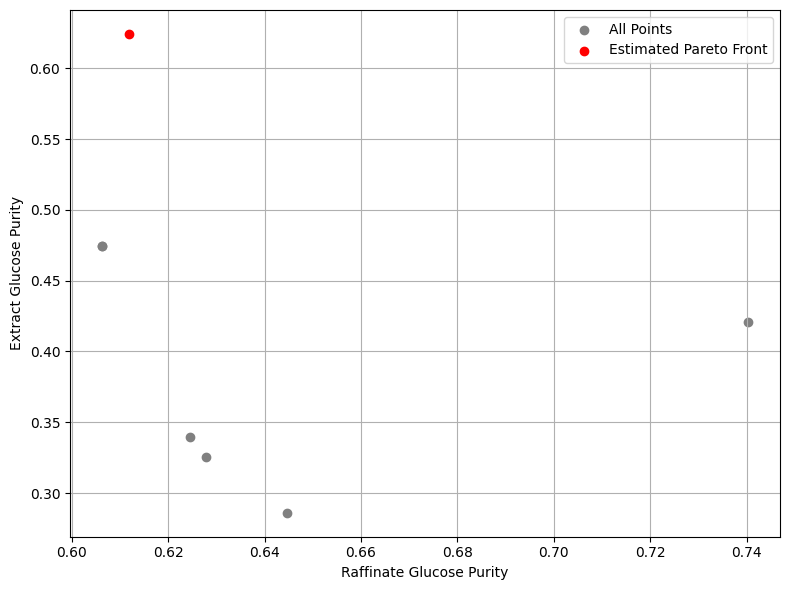

In [ ]:
plt.figure(figsize=(8, 6))

# Plot evaluated points and estimated Pareto front from your model
plt.scatter(all_initial_ouputs[:,0], all_initial_ouputs[:,1], c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Estimated Pareto Front")

# Plot labels and styling
plt.xlabel("Raffinate Glucose Purity")
plt.ylabel("Extract Glucose Purity")
# plt.title(f'Varrying t_index @ fixed flowrates\n {pop_size} initial points & {num_generations} iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('Opt_Par_new.png')

plt.show()

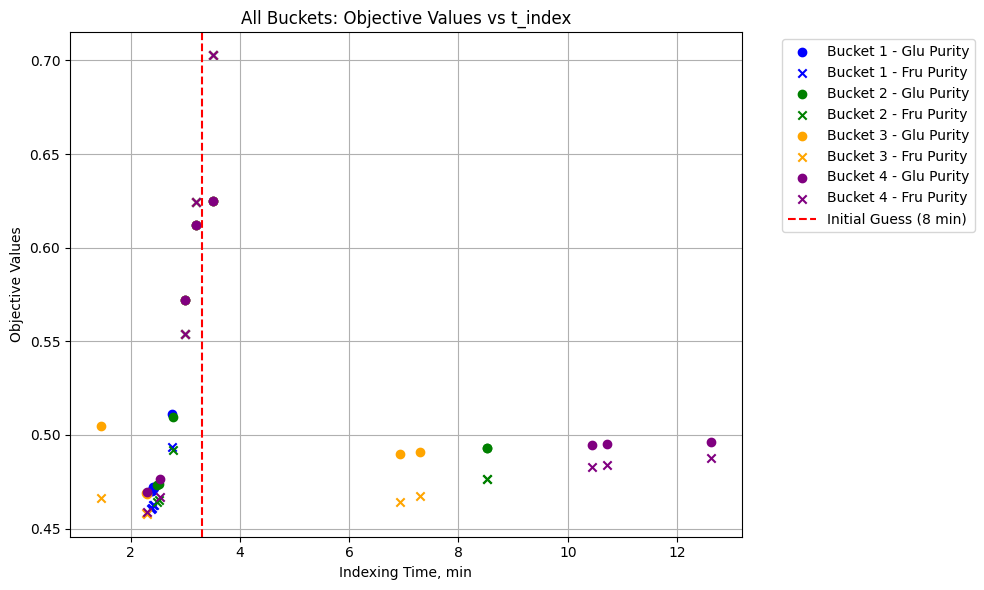

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'orange', 'purple', 'brown', 'gray', 'teal', 'magenta']  # extend as needed

for i in range(bucket_size):
    # Safely extract t_index population for this bucket
    t_idx_vals = np.array([row[-1] for row in all_initial_inputs if row[-1] != 0])  # or use a better mask if available

    # Get f1 and f2 values for this bucket
    f1_vals = np.array(all_f1_all[i])
    f2_vals = np.array(all_f2_all[i])

    # Sanity check: match t_idx length with f1/f2
    if len(t_idx_vals) != len(f1_vals):
        t_idx_vals = t_idx_vals[:len(f1_vals)]  # truncate safely just in case

    # Plot Glu Purity
    plt.scatter(t_idx_vals, f1_vals, c=colors[i % len(colors)], marker='o', label=f'Bucket {i+1} - Glu Purity')

    # Plot Fru Purity
    plt.scatter(t_idx_vals, f2_vals, c=colors[i % len(colors)], marker='x', label=f'Bucket {i+1} - Fru Purity')

# Add initial guess line
plt.axvline(x=initial_guess, color='red', linestyle='--', label=f'Initial Guess ({initial_guess} min)')

# Labels and formatting
plt.xlabel("Indexing Time (min)", fontsize=12)
plt.ylabel("Objective Values (Purity)", fontsize=12)
plt.title("All Buckets: Glu & Fru Purity vs t_index", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('all_buckets_glu_fru.png', dpi=300)
plt.show()


OPTIMIZER
 - Feed is always fixed
 - Select which (and how many) input parameters to vary with t_index

FUNCTIONS FOR OPTIMIZATION

In [112]:
def constraint_objectives(params, Q_fixed_feed, gen):
  """

  params = [QD, QX, t_index]
  Returns: Objective f1 and f2 (For Recoveries), and the 2 constrains (on the Purity)
  Units:
  - time in min
  - flowrates in cm^3/s


  """

  # Unpack
  QD = params[0] # cm^3/s
  QX = -params[1] # cm^3/s ENSURE this is negative value
  t_index = params[2] # min


  # ----- Caclulate QR, using vol balance
  vol_in = Q_fixed_feed + QD # cm^3/s
  QR = -(vol_in + QX) # SINCE abs(vol_in) > abs(QX)
  # -----

  num_of_params = len(params) # [QD, QX, t_index]

  # print(f"you called?")
  # print(f'params: {params} [0,1]')
  Q_external = np.array([Q_fixed_feed, QR, QD, QX])
  Q_internal = Q_external_to_internal(Q_external, 0.567) # Q_rec = 0.567 # cm^3/s (Subramani et al)

  # ----- Check Balance
  # print(f'sampled flowrates:\n {Q_external} cm^3/s \n {Q_external*3.6} L/h \n internal: {Q_internal*3.6} L/h')
  if (Q_fixed_feed + QD) - abs(QR + QX) < 0.001:
    print(f'Gen {gen+1} MB closed: {(Q_fixed_feed + QD) - abs(QR + QX)}')
  else:
    print(f'Gen {gen+1} MB NOT closed, error: {(Q_fixed_feed + QD) - abs(QR + QX)}')
  # -----

  # Update SMB_inputs:
  #index time in min
  SMB_inputs[12] = t_index  # Update t_index
  # flowrates
  SMB_inputs[14] = Q_internal  # Update internal flowrates


  # Run the SMB simulation
  results = SMB(SMB_inputs)

  # Get the contraint variables:
  # (1) Glu Raff Pur > 99.5%
  # (2) Fru Ext Pur > 99.5%

    # Extract relevant outputs
  raff_purity = results[10] # [Glu, Fru]
  ext_purity = results[12]  # [Glu, Fru]

  raff_recovery = results[11] # [Glu, Fru]
  ext_recovery = results[13]  # [Glu, Fru]

  # Assign objectives and constrains:
  # Recovery Objectives
  f1 = raff_recovery[0]/100
  f2 = ext_recovery[1]/100

  # Purity Constraints
  c1 = raff_purity[0]/100
  c2 = ext_purity[1]/100


  # constraint_vals = np.array([c1, c2])

  # print(f'Q_desorbant: {Q_desorbant*3.6} L/h, constraint_vals: {constraint_vals} %')
  return f1, f2, c1, c2, Q_external


def expected_constrained_improvement(x, surrogate_obj_gp, constraint_1_gp, constraint_2_gp,
                                     constraint_thresholds, y_best, xi=0.01):
    """
    Computes the Expected Constrained Improvement (ECI) at a point x.

    Parameters:
    - x : array-like, input point
    - surrogate_obj_gp : GaussianProcessRegressor for the objective function
    - constraint_1_gp : GaussianProcessRegressor for first constraint
    - constraint_2_gp : GaussianProcessRegressor for second constraint
    - constraint_thresholds : list or array of constraint thresholds [lambda1, lambda2]
    - y_best : float, best observed objective value
    - xi : float, exploration-exploitation trade-off parameter

    Returns:
    - improve : float, expected constrained improvement
    """

    x = np.asarray(x).reshape(1, -1)

    # Objective GP prediction
    mu_obj, sigma_obj = surrogate_obj_gp.predict(x, return_std=True)

    with np.errstate(divide='warn'):
        Z = (y_best - mu_obj - xi) / sigma_obj
        ei = (y_best - mu_obj - xi) * norm.cdf(Z) + sigma_obj * norm.pdf(Z)

    # Compute probability of feasibility
    prob_feas = 1.0
    constraint_gps = [constraint_1_gp, constraint_2_gp]

    for gp_c, lam in zip(constraint_gps, constraint_thresholds):
        mu_c, sigma_c = gp_c.predict(x, return_std=True)
        pf = 1 - norm.cdf((lam - mu_c) / sigma_c)

        # Handle potential zero-probability
        pf = pf[pf != 0]
        if len(pf) > 0:
            prob_feas *= pf[0]
        else:
            prob_feas *= 0  # If completely infeasible

    eic = ei * prob_feas

    # Prevent over-squashing
    epsilon = 1e-8
    improve = ei if eic < epsilon else eic

    return improve[0] if isinstance(improve, np.ndarray) else improve





def constrained_BO(optimization_budget, bounds,Q_fixed_feed, initial_guess, all_initial_inputs, all_initial_ouputs, constraint_thresholds, xi):

    # xi = exploration param

    # Initial values
    # UNpack from: all_initial_ouputs: [GPur, FPur, GRec, FRec]
    # Recovery Objectives
    f1_vals = all_initial_ouputs[:,2]
    f2_vals = all_initial_ouputs[:,3]

    # Purity constraints
    c1 = all_initial_ouputs[:,0]
    c2 = all_initial_ouputs[:,1]

    all_inputs = np.zeros((sampling_budget+optimization_budget, 5)) # [QF, QR, QD, QX, t_index]
    # print(f'np.shape(all_inputs):{np.shape(all_inputs)}')
    # print(f'np.shape(all_initial_inputs):{np.shape(all_initial_inputs)}')
    all_inputs = np.vstack((all_inputs, all_initial_inputs))

    # Unpack from: all_initial_inputs
    # Remove QR & QF inputs - the first 2 cols
    # Remain with [QD, QX, t_index]
    population = np.delete(all_initial_inputs, [0,1], axis=1)

    # print(f'shpae_f1_vals = {np.shape(f1_vals)}')

    # Initialize where we will store solutions
    population_all = []
    all_constraint_1_gps = []
    all_constraint_2_gps = []
    ei_all = []


    for gen in range(optimization_budget):
        # generation = iteration
        print(f"Starting gen {gen+1}")


        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # print(f'weights: {weights}')
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        #SCALARIZE THE OBJECTIVES (BEFORE APPLYING GP)
        scalarized_f_vals = scalarized_surrogate_objective(f1_vals, f2_vals, weights)

        # Fit GP to scalarized_surrogate_objective
        # print(f'population { population}, \nscalarized_f_vals {scalarized_f_vals} ')
        scalarized_surrogate_gp = surrogate_model(population, scalarized_f_vals)
        # Pull mean at relevant poputlation points
        # Mean & Varriance
        scalarized_surrogate_gp_mean, scalarized_surrogate_gp_std = scalarized_surrogate_gp.predict(population, return_std=True)
        # The best value so far:
        y_best = np.max(scalarized_surrogate_gp_mean)


        print(f'Maxing ECI')

        # Fit a GP to each constraint:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Glu Raff Purity:
            constraint_1_gp = surrogate_model(population, c1)
            all_constraint_1_gps.append(constraint_1_gp)
            # Fru Ext Purity:
            constraint_2_gp = surrogate_model(population, c2)
            all_constraint_2_gps.append(constraint_2_gp)

        # Define the constraint function for the ei optimizer
        def constraint(x, Q_fixed_feed):
            return (x[0] + Q_fixed_feed) * 0.7 - x[1]
        # --- Run the optimization ---
        # Create a NonlinearConstraint object
        nonlinear_constraint = NonlinearConstraint(lambda x: constraint(x, Q_fixed_feed), 0, np.inf)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            result = differential_evolution(
                func=expected_constrained_improvement,
                bounds=bounds,
                args=(scalarized_surrogate_gp, constraint_1_gp, constraint_2_gp, constraint_thresholds, y_best, xi),  # weights for scalarized f1 and f2
                strategy='best1bin',
                maxiter=200,
                popsize=15,
                disp=False,
                constraints=(nonlinear_constraint,)
            )
                # Perform the optimization using L-BFGS-B method
        # result = minimize(
        #     expected_improvement,
        #     initial_guess,
        #     args=(scalarized_surrogate_gp, y_best),
        #     method='L-BFGS-B',
        #     bounds=bounds,
        #     options={'maxiter': 100, 'disp': True})

        x_new = result.x
        # print(f"x_new: { x_new}")

        # f1_new = objective_f1(x_new)
        # f2_new = objective_f2(x_new)

        # print(f'Calling smb_func for the {gen}th time')
        f1_new, f2_new, c1_new, c2_new, Q_external_new = constraint_objectives(x_new, Q_fixed_feed, gen)
        # print()
        # Concatenate Q_external_new and x_new along the second axis
        new_row = np.hstack((Q_external_new, x_new[-1]))

        # Add the new row to all_inputs
        all_inputs = np.vstack((all_inputs, new_row))

        # Add to population
        population_all.append(population)
        population = np.vstack((population, x_new))

        f1_vals = np.vstack([f1_vals.reshape(-1,1), f1_new])
        f2_vals = np.vstack([f2_vals.reshape(-1,1), f2_new])
        c1 = np.vstack([c1.reshape(-1,1), c1_new])
        c2 = np.vstack([c2.reshape(-1,1), c2_new])

        print(f"\nGen {gen+1} Status:\n | Sampled Inputs:{Q_external_new*3.6} L/h [QF,QR,QD,QX] and {x_new[-1]} min|\n Outputs: f1: {f1_new}, f2: {f2_new} | GPur, FPur: {c1_new}, {c2_new}")

    return population_all, f1_vals, f2_vals, c1, c2, all_inputs

OPTMIZATION ROUTINE

In [113]:
constraint_thresholds = [0.75, 0.75] # (Purity constraints) will scale with increased col#

bounds = [(Q_min, Q_max), (Q_min, Q_max), (1, 15)] # cm^3/s and min . .[QD, QX, t_idx]
optimization_budget = 5 # iterations
initial_guess = 0 # min
population_all, f1_vals, f2_vals, c1_vals, c2_vals, all_inputs  = constrained_BO(optimization_budget, bounds,Q_fixed_feed, initial_guess, all_initial_inputs, all_initial_ouputs, constraint_thresholds, 0.001)

# print(f'population_all: {population_all}')
# print(f'populatation.shape: {np.shape(population)}')

Starting gen 1
Maxing ECI
Gen 1 MB closed: 0.0

Gen 1
 | Sampled Inputs:[ 0.2016     -0.21911482  0.29165135 -0.27413652] L/h [QF,QR,QD,QX] and 8.291706832217923 min|
 Outputs: f1: 0.44666577477986286, f2: 0.41326507517530364 | GPur, FPur: 0.5020130608009086, 0.4836683496684123
Starting gen 2
Maxing ECI
Gen 2 MB closed: 0.0


KeyboardInterrupt: 

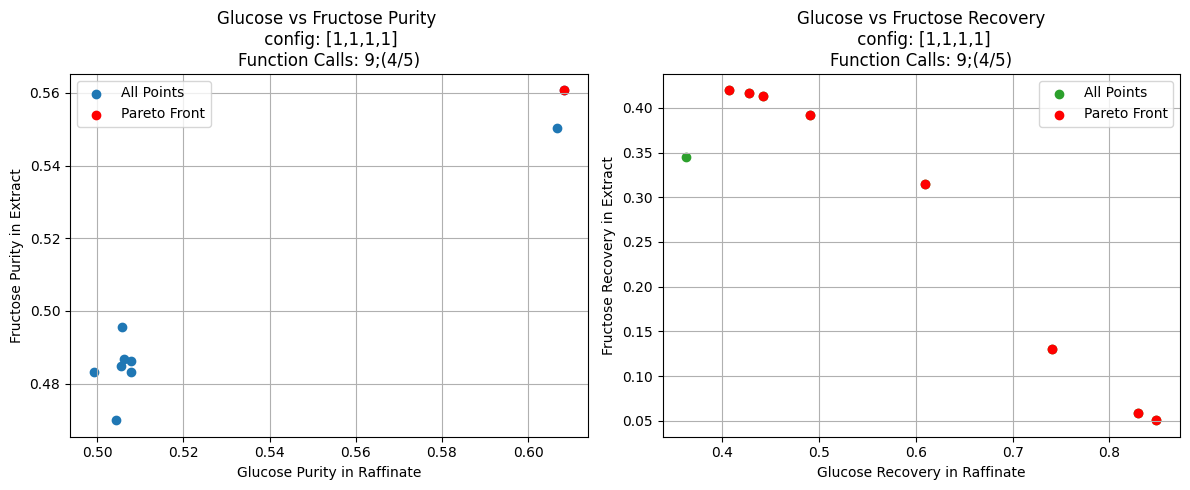

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Function to identify Pareto front indices
def identify_pareto(points):
    is_pareto = np.ones(points.shape[0], dtype=bool)
    for i, point in enumerate(points):
        if is_pareto[i]:
            is_pareto[is_pareto] = np.any(points[is_pareto] > point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True  # keep self in the front
    return is_pareto

# Stack purity and recovery values
purity_points = np.column_stack((c1_vals, c2_vals))
recovery_points = np.column_stack((f1_vals, f2_vals))

# Identify Pareto front indices
pareto_purity_mask = identify_pareto(purity_points)
pareto_recovery_mask = identify_pareto(recovery_points)

# Create figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot 1: Purity comparison
axs[0].scatter(c1_vals, c2_vals, color='tab:blue', label='All Points')
axs[0].scatter(c1_vals[pareto_purity_mask], c2_vals[pareto_purity_mask], color='red', label='Pareto Front')
axs[0].set_xlabel('Glucose Purity in Raffinate')
axs[0].set_ylabel('Fructose Purity in Extract')
axs[0].set_title(f'Glucose vs Fructose Purity \n config: [{Z1},{Z2},{Z3},{Z4}]\nFunction Calls: {sampling_budget+optimization_budget};({sampling_budget}/{+optimization_budget})')
axs[0].grid(True)
axs[0].legend()

# Scatter plot 2: Recovery comparison
axs[1].scatter(f1_vals, f2_vals, color='tab:green', label='All Points')
axs[1].scatter(f1_vals[pareto_recovery_mask], f2_vals[pareto_recovery_mask], color='red', label='Pareto Front')
axs[1].set_xlabel('Glucose Recovery in Raffinate')
axs[1].set_ylabel('Fructose Recovery in Extract')
axs[1].set_title(f'Glucose vs Fructose Recovery\n config: [{Z1},{Z2},{Z3},{Z4}]\nFunction Calls: {sampling_budget+optimization_budget};({sampling_budget}/{+optimization_budget})')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


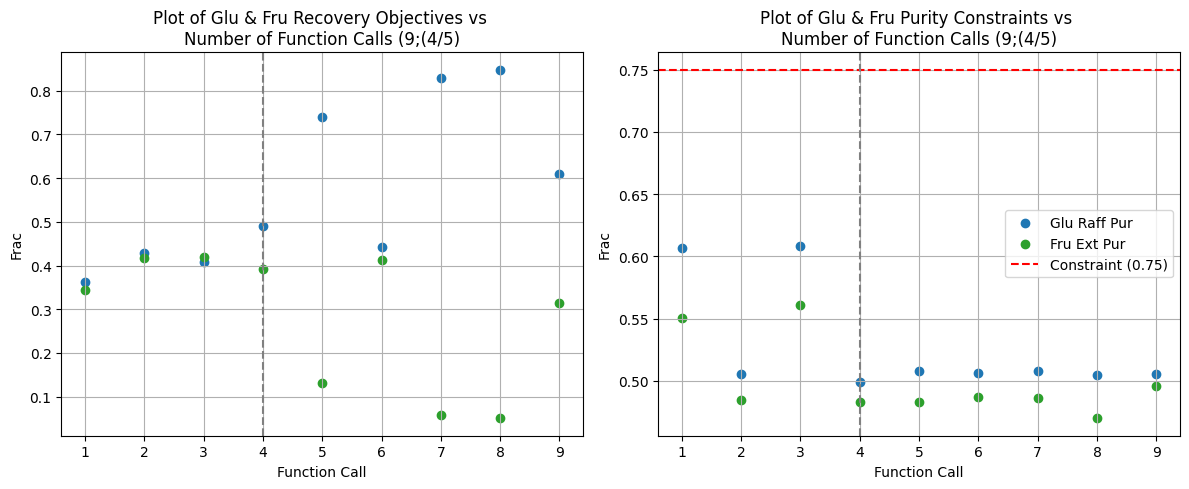

In [102]:
# print(f"c1_vals:\n {c1_vals}, \nc2_vals:\n {c2_vals}")
import matplotlib.pyplot as plt

# Create figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
iter = np.linspace(1,len(c2_vals), len(c2_vals))
# Scatter plot 1: Recovery comparison
axs[0].scatter(iter, f1_vals, color='tab:blue', label='Glu Raff Rec')
axs[0].scatter(iter, f2_vals, color='tab:green', label='Fru Ext Rec')
# axs[0].axhline(0.75, color='red', linestyle='--', label='Target (75%)')
axs[0].axvline(x=sampling_budget, color='grey', linestyle='--')
axs[0].set_xlabel('Function Call')
axs[0].set_ylabel('Frac')
axs[0].set_title(f'Plot of Glu & Fru Recovery Objectives vs \nNumber of Function Calls ({sampling_budget+optimization_budget};({sampling_budget}/{+optimization_budget})')
axs[0].grid(True)

# Scatter plot 2: Purity comparison
axs[1].scatter(iter, c1_vals, color='tab:blue', label='Glu Raff Pur')
axs[1].scatter(iter, c2_vals, color='tab:green', label='Fru Ext Pur')
axs[1].axhline(0.75, color='red', linestyle='--', label=f'Constraint ({constraint_thresholds[0]})')
axs[1].axvline(x=sampling_budget, color='grey', linestyle='--')
axs[1].set_xlabel('Function Call')
axs[1].set_ylabel('Frac')
plt.legend()
axs[1].set_title(f'Plot of Glu & Fru Purity Constraints vs \nNumber of Function Calls ({sampling_budget+optimization_budget};({sampling_budget}/{+optimization_budget})')
axs[1].grid(True)



# Adjust layout
plt.tight_layout()
plt.legend()
plt.show()
